In [38]:
# 1. Load and Preprocess Burglary Data

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load data and aggregate to ward-monthly counts
burglary = pd.read_csv("../data/residential_burglary.csv")

# Combine 'Year' and 'Month' into a single datetime column
burglary ["Month"] = pd.to_datetime(burglary ["Year"].astype(str) + "-" + burglary ["Month"].astype(str), format="%Y-%m")

burglary_monthly = burglary.groupby(["Ward Code", "Month"]).size().reset_index(name="Count")

# Extract the year from the 'Month' column for merging with the population data
burglary_monthly["Year"] = burglary_monthly["Month"].dt.year

print("Raw data overview:")
print(f"Total wards: {burglary_monthly['Ward Code'].nunique()}")
print(f"Time range: {burglary_monthly['Month'].min()} to {burglary_monthly['Month'].max()}")

burglary_monthly


Raw data overview:
Total wards: 679
Time range: 2013-12-01 00:00:00 to 2025-02-01 00:00:00


,Ward Code,Month,Count,Year
0,E05009317,2013-12-01,8,2013
1,E05009317,2014-01-01,23,2014
2,E05009317,2014-02-01,12,2014
3,E05009317,2014-03-01,11,2014
4,E05009317,2014-04-01,21,2014
...,...,...,...,...
89633,E05014119,2024-10-01,1,2024
89634,E05014119,2024-11-01,2,2024
89635,E05014119,2024-12-01,4,2024
89636,E05014119,2025-01-01,3,2025


In [39]:
# 2. Load and process car ownership data

cars_df = pd.read_excel("../data/housing/cars_or_vans_wards.xlsx", sheet_name="2021")
cars_df["NoCarPct"] = (cars_df["none"] / cars_df["All households"])

occupancy_df = pd.read_excel("../data/housing/occupancy_rating_bedrooms_wards.xlsx", sheet_name="2021")
occupancy_df["ZeroRoomPct"] = (occupancy_df["0"] / occupancy_df["All Households"])

cluster_df = pd.merge(cars_df, occupancy_df, on="ward code", how="inner")

print(f"Wards with both SARIMA and socio-economic data: {len(cluster_df)}")

cluster_df

Wards with both SARIMA and socio-economic data: 679


,ward code,ward name_x,local authority code_x,local authority name_x,All households,none,one,two,three or more,NoCarPct,ward name_y,local authority code_y,local authority name_y,All Households,Occupancy rating: +2 or more,+1,0,-1,-2 or less,ZeroRoomPct
0,E05014053,Abbey,E09000002,Barking and Dagenham,1453.0,950.0,412.0,79.0,12.0,0.653820,Abbey,E09000002,Barking and Dagenham,1455,102,225,754,327,47,0.518213
1,E05014054,Alibon,E09000002,Barking and Dagenham,3343.0,1086.0,1518.0,583.0,156.0,0.324858,Alibon,E09000002,Barking and Dagenham,3337,516,977,1288,454,102,0.385975
2,E05014055,Barking Riverside,E09000002,Barking and Dagenham,3391.0,1060.0,1777.0,465.0,89.0,0.312592,Barking Riverside,E09000002,Barking and Dagenham,3385,336,831,1591,515,112,0.470015
3,E05014056,Beam,E09000002,Barking and Dagenham,2699.0,900.0,1237.0,445.0,117.0,0.333457,Beam,E09000002,Barking and Dagenham,2703,520,738,992,371,82,0.367000
4,E05014057,Becontree,E09000002,Barking and Dagenham,3074.0,910.0,1409.0,567.0,188.0,0.296031,Becontree,E09000002,Barking and Dagenham,3071,452,822,1223,445,129,0.398242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
674,E05013805,Regent's Park,E09000033,Westminster,5655.0,3543.0,1686.0,336.0,90.0,0.626525,Regent's Park,E09000033,Westminster,5649,951,1680,2657,309,52,0.470349
675,E05013806,St James's,E09000033,Westminster,5159.0,3914.0,995.0,195.0,55.0,0.758674,St James's,E09000033,Westminster,5147,552,1422,2879,261,33,0.559355
676,E05013807,Vincent Square,E09000033,Westminster,5158.0,3544.0,1379.0,208.0,27.0,0.687088,Vincent Square,E09000033,Westminster,5170,482,1428,2767,401,92,0.535203
677,E05013808,West End,E09000033,Westminster,6072.0,4480.0,1249.0,277.0,66.0,0.737813,West End,E09000033,Westminster,6076,681,1607,3368,348,72,0.554312


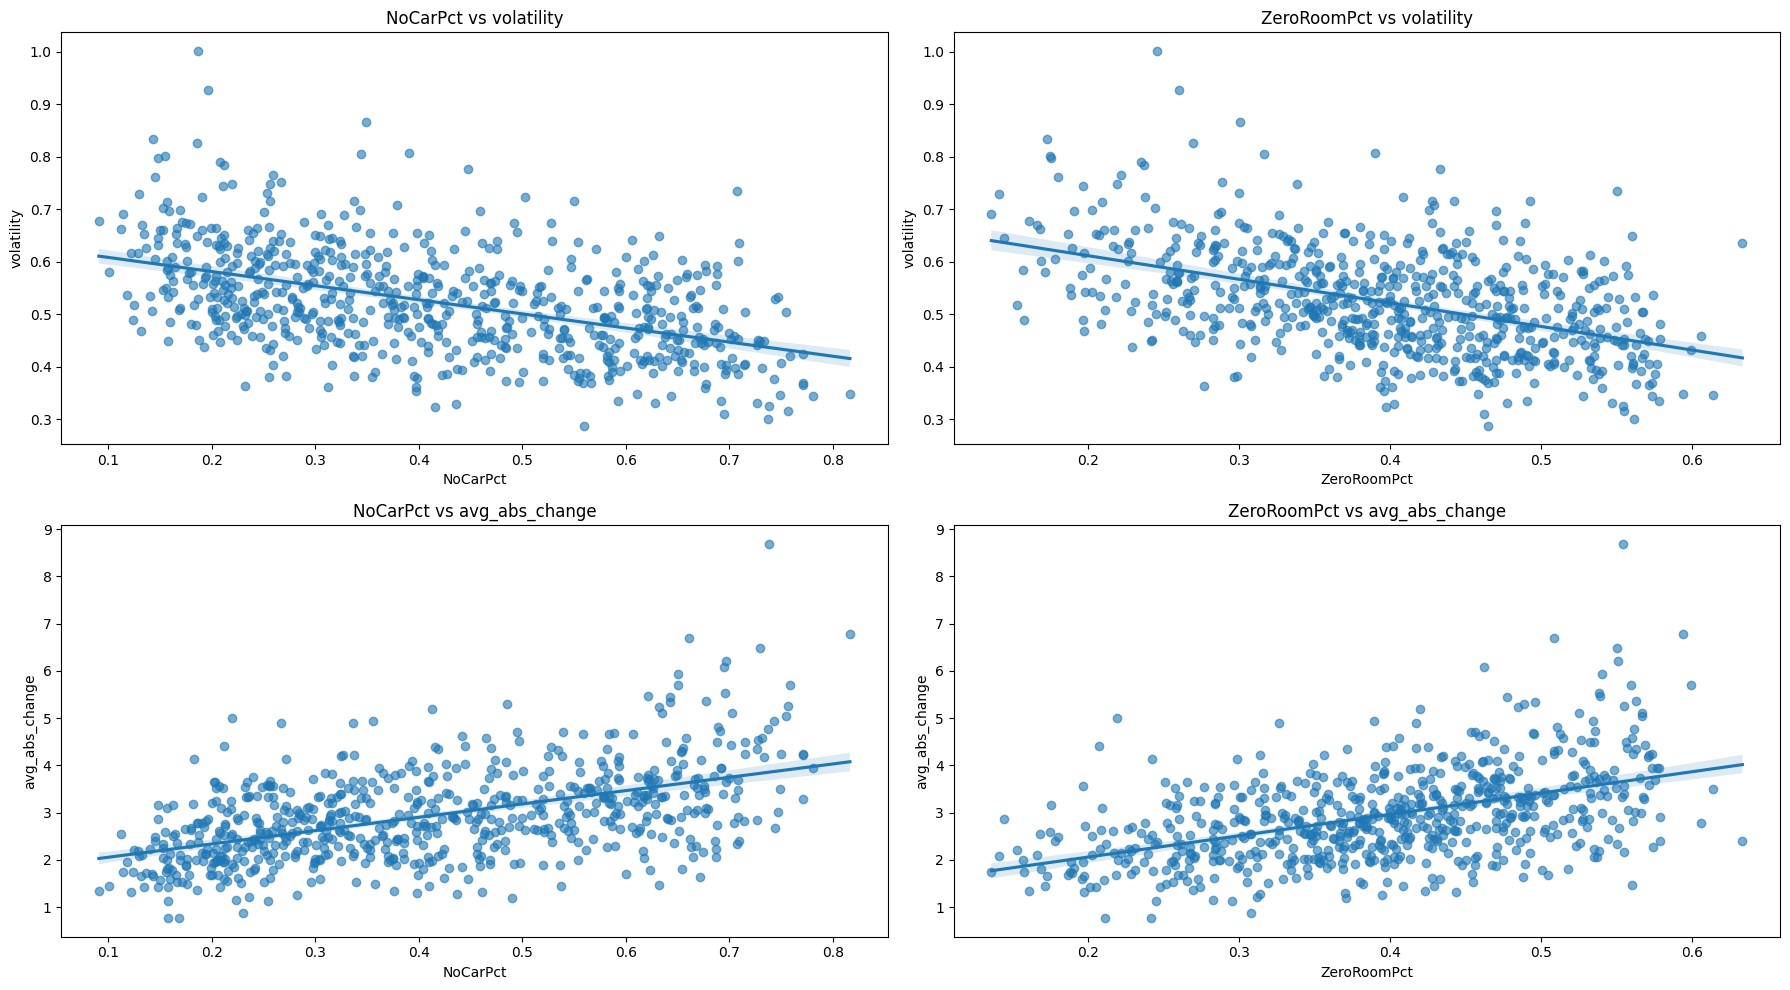


Correlation Matrix:
                volatility  avg_abs_change  NoCarPct  ZeroRoomPct
volatility        1.000000       -0.432192 -0.477757    -0.472011
avg_abs_change   -0.432192        1.000000  0.514565     0.487126
NoCarPct         -0.477757        0.514565  1.000000     0.910007
ZeroRoomPct      -0.472011        0.487126  0.910007     1.000000


In [40]:
# Extra testing of social-economic factors vs. data property

import seaborn as sns


def calculate_stability_metrics(ward_series):
    """Compute multiple stability metrics for a ward's burglary data"""
    # 1. Volatility Index (relative standard deviation)
    volatility = ward_series.std() / ward_series.mean()

    # 2. Average Absolute Change (temporal instability)
    abs_changes = np.abs(np.diff(ward_series))
    avg_abs_change = np.mean(abs_changes)

    return {
        "volatility": volatility,
        "avg_abs_change": avg_abs_change,
    }

# Compute stability metrics for all wards
stability_data = []
for ward_code, group in burglary_monthly.groupby("Ward Code"):
    group = group[group["Month"] > "2020-12-01"]
    ward_series = group.set_index("Month")["Count"]
    metrics = calculate_stability_metrics(ward_series)
    metrics["ward code"] = ward_code
    stability_data.append(metrics)

stability_df = pd.DataFrame(stability_data)

# Merge with socio-economic data
full_stability_df = pd.merge(
    stability_df,
    cluster_df[["ward code", "NoCarPct", "ZeroRoomPct"]].drop_duplicates(),
    on="ward code",
    how="inner"
)

# Plot relationships
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

for i, metric in enumerate(["volatility", "avg_abs_change"]):
    # No Car Percentage
    sns.regplot(
        x="NoCarPct",
        y=metric,
        data=full_stability_df,
        ax=axes[i, 0],
        scatter_kws={"alpha": 0.6}
    )
    axes[i, 0].set_title(f"NoCarPct vs {metric}")

    # Zero Room Percentage
    sns.regplot(
        x="ZeroRoomPct",
        y=metric,
        data=full_stability_df,
        ax=axes[i, 1],
        scatter_kws={"alpha": 0.6}
    )
    axes[i, 1].set_title(f"ZeroRoomPct vs {metric}")

plt.tight_layout()
plt.show()

# Calculate correlation matrix
corr_matrix = full_stability_df[["volatility", "avg_abs_change", "NoCarPct", "ZeroRoomPct"]].corr()
print("\nCorrelation Matrix:")
print(corr_matrix)

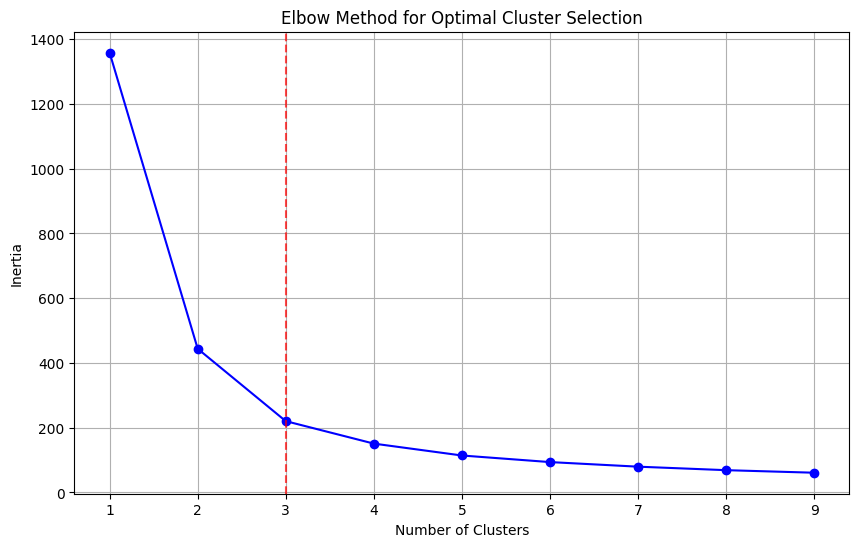

Cluster 0 have 233 observations
Cluster 1 have 265 observations
Cluster 2 have 181 observations


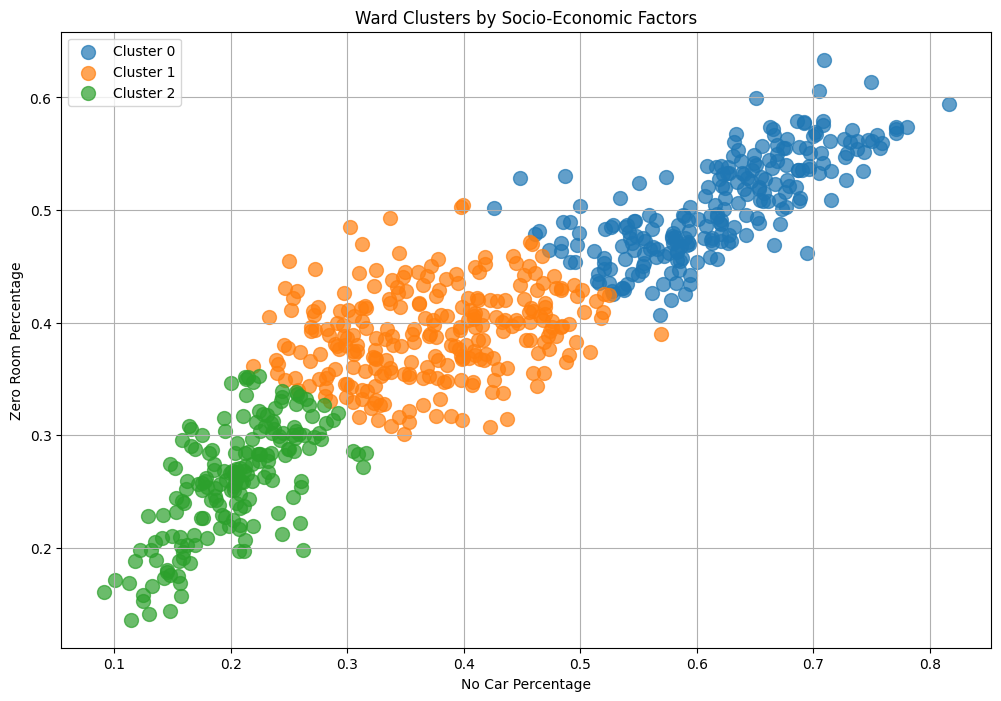

,ward_code,NoCarPct,ZeroRoomPct,cluster
0,E05014053,0.653820,0.518213,0
1,E05014054,0.324858,0.385975,1
2,E05014055,0.312592,0.470015,1
3,E05014056,0.333457,0.367000,1
4,E05014057,0.296031,0.398242,1
...,...,...,...,...
674,E05013805,0.626525,0.470349,0
675,E05013806,0.758674,0.559355,0
676,E05013807,0.687088,0.535203,0
677,E05013808,0.737813,0.554312,0


In [41]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Prepare data
X = cluster_df[["NoCarPct", "ZeroRoomPct"]]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine optimal clusters
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 10), inertia, "bo-")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal Cluster Selection")
plt.axvline(x=3, color="r", linestyle="--", alpha=0.7)
plt.grid(True)
plt.show()

# Fit final clusters (using k=3 from elbow)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)
cluster_df["cluster"] = clusters

# Visualize clusters
plt.figure(figsize=(12, 8))
for cluster_id in range(3):
    cluster_data = X[clusters == cluster_id]
    print(f"Cluster {cluster_id} have {len(cluster_data)} observations")
    plt.scatter(cluster_data["NoCarPct"], cluster_data["ZeroRoomPct"],
                label=f"Cluster {cluster_id}", alpha=0.7, s=100)

# plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], =300, c='black', marker='X', label='Centroids')
plt.xlabel("No Car Percentage")
plt.ylabel("Zero Room Percentage")
plt.title("Ward Clusters by Socio-Economic Factors")
plt.legend()
plt.grid(True)
plt.show()

# # Merge clusters back to main data
cluster_df = (cluster_df[["ward code", "NoCarPct", "ZeroRoomPct", "cluster"]]
              .rename(columns={"ward code": "ward_code"})
              .copy())

cluster_df

In [44]:
import warnings

warnings.filterwarnings("ignore")

def oscillation_capture_score(actual, predicted):
    """Calculate a composite score that detects oscillation pattern matching"""
    n = len(actual)
    if n < 3:
        return 0.0  # Not enough data

    # 1. Detrended Variability Ratio (DVR)
    var_actual = np.var(actual)
    var_pred = np.var(predicted)

    # Handle near-zero variance cases
    if var_actual < 1e-10 and var_pred < 1e-10:
        dvr = 1.0
    elif var_actual < 1e-10:
        dvr = 0.0
    else:
        dvr = min(var_pred / var_actual, 2.0)  # Cap at 2.0

    # 2. Smoothness Penalty (SP)
    pred_diff = np.diff(predicted)
    sp = 1 - np.exp(-np.mean(np.abs(pred_diff)) / max(1, np.mean(np.abs(np.diff(actual)))))

    # Combine components
    ocs = 0.5 * dvr + 0.5 * sp
    return ocs, dvr, sp

# Define optimal orders for each cluster
# Rationale for cluster-specific orders:
# - Cluster 2 (High Deprivation): Higher q (3) for responsiveness to large absolute changes
# - Cluster 0 (Low Deprivation): Higher p (2) for capturing persistent patterns
# - All clusters: Reduced seasonal complexity (P≤1) based on your findings
CLUSTER_ORDERS = {
    0: {"normal": (1,1,3), "seasonal": (0,1,3,12)},  # High deprivation
    1: {"normal": (2,1,2), "seasonal": (0,1,2,12)},   # Medium deprivation
    2: {"normal": (3,1,1), "seasonal": (0,1,1,12)}   # Low deprivation
}
TEST_MONTHS = 26

def analyze_ward_cluster(args):
    ward_code, ward_df = args
    try:
        # Get cluster-specific orders
        cluster_id = cluster_df[cluster_df["ward_code"] == ward_code]["cluster"].values[0]
        orders = CLUSTER_ORDERS[cluster_id]

        # Prepare dataframe
        ward_df = ward_df[["Month", "Count"]].set_index("Month").asfreq("MS")

        # print(ward_df)

        if ward_df.isnull().values.any():
            print(f"{ward_code} has NaN values")
            if ward_df.isnull().sum().sum() > 10:
                print(f"{ward_code} has more than 10 NaN values, aborted")
                return None
            ward_df.ffill(inplace=True)

        # Filter wards with sufficient history
        if len(ward_df) < TEST_MONTHS * 2:
            print(f"{ward_code} has insufficient data")
            return None

        # Split data
        train = ward_df.iloc[:-TEST_MONTHS]
        test = ward_df.iloc[-TEST_MONTHS:]

        # print(train)

        # Fit SARIMAX with cluster-specific orders
        model = SARIMAX(train["Count"],
                       order=orders["normal"],
                       seasonal_order=orders["seasonal"])  # Using cluster-defined seasonal order
        results = model.fit(disp=False)

        # Generate predictions
        preds = results.get_forecast(steps=TEST_MONTHS).predicted_mean

        # Calculate residuals
        residuals = test["Count"].values - preds.values

        ocs, dvr, sp = oscillation_capture_score(test["Count"].values, preds.values)

        print(f"{ward_code} completed")

        return {
            "ward_code": ward_code,
            "cluster": cluster_id,
            "residuals": residuals,
            "predicted": preds.values,
            "fitting_score_1": ocs,
            "fitting_score_2": dvr,
            "fitting_score_3": sp,
            "actual": test["Count"].values,
            "orders_normal": orders["normal"],
            "orders_seasonal": orders["seasonal"]
        }
    except Exception as e:
        print(f"Error processing {ward_code}: {e!s}")
        return None

# Process all wards
results = []
# i = 0
for ward_code, group in burglary_monthly.groupby("Ward Code"):
    analysis = analyze_ward_cluster((ward_code, group))
    if analysis:
        results.append(analysis)
        # i += 1
    # if i > 2:
    #     break   # just to test a few wards, not all

# Remove Empty results
results = [res for res in results if res is not None]

print(f"\nSuccessfully processed {len(results)} wards with sufficient data")

warnings.filterwarnings("default")


E05009317 completed
E05009318 completed
E05009319 completed
E05009320 completed
E05009321 has NaN values
E05009321 completed
E05009322 completed
E05009323 completed
E05009324 has NaN values
E05009324 completed
E05009325 completed
E05009326 has NaN values
E05009326 has more than 10 NaN values, aborted
E05009327 completed
E05009328 has NaN values
E05009328 has more than 10 NaN values, aborted
E05009329 completed
E05009330 completed
E05009331 completed
E05009332 completed
E05009333 completed
E05009334 completed
E05009335 completed
E05009336 completed
E05009367 has NaN values
E05009367 completed
E05009368 has NaN values
E05009368 completed
E05009369 completed
E05009370 completed
E05009371 completed
E05009372 completed
E05009373 completed
E05009374 completed
E05009375 completed
E05009376 completed
E05009377 completed
E05009378 completed
E05009379 completed
E05009380 completed
E05009381 completed
E05009382 completed
E05009383 completed
E05009384 has NaN values
E05009384 completed
E05009385 c


Cluster Performance Metrics:
   cluster  n_wards   avg_mae  avg_rmse  avg_fitting_score_1  \
0        0      225  3.325997  4.147470             0.301856   
1        1      255  2.775395  3.470273             0.351381   
2        2      151  2.398625  3.074387             0.426968   

   avg_fitting_score_2  avg_fitting_score_3  
0             0.232271             0.371442  
1             0.310799             0.391962  
2             0.440678             0.413258  


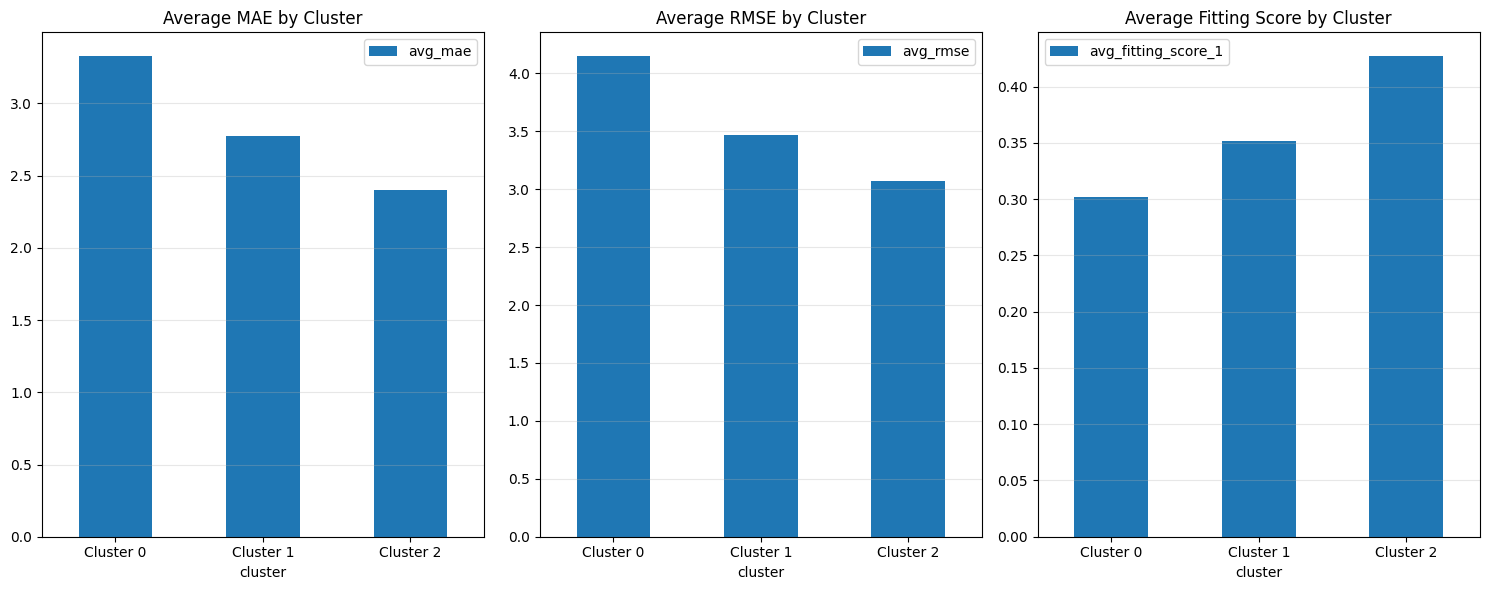

In [45]:
# Calculate metrics per cluster

results_df = pd.DataFrame(results)

cluster_results = []
for cluster_id in range(3):
    cluster_data = results_df[results_df["cluster"] == cluster_id]
    cluster_mae = cluster_data["residuals"].apply(lambda x: np.mean(np.abs(x))).mean()
    cluster_rmse = cluster_data["residuals"].apply(lambda x: np.sqrt(np.mean(np.square(x)))).mean()

    cluster_results.append({
        "cluster": cluster_id,
        "n_wards": len(cluster_data),
        "avg_mae": cluster_mae,
        "avg_rmse": cluster_rmse,
        "avg_fitting_score_1": cluster_data["fitting_score_1"].mean(),
        "avg_fitting_score_2": cluster_data["fitting_score_2"].mean(),
        "avg_fitting_score_3": cluster_data["fitting_score_3"].mean(),
        "normal_order": CLUSTER_ORDERS[cluster_id]["normal"],
        "seasonal_order": CLUSTER_ORDERS[cluster_id]["seasonal"]
    })

# Display results
cluster_metrics = pd.DataFrame(cluster_results)
print("\nCluster Performance Metrics:")
print(cluster_metrics[["cluster", "n_wards", "avg_mae", "avg_rmse", "avg_fitting_score_1", "avg_fitting_score_2", "avg_fitting_score_3"]])   # , 'normal_order', 'seasonal_order'

# Visualize comparison
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
cluster_metrics.plot(x="cluster", y="avg_mae", kind="bar", ax=ax[0], title="Average MAE by Cluster")
cluster_metrics.plot(x="cluster", y="avg_rmse", kind="bar", ax=ax[1], title="Average RMSE by Cluster")
cluster_metrics.plot(x="cluster", y="avg_fitting_score_1", kind="bar", ax=ax[2], title="Average Fitting Score by Cluster")
for i in range(3):
    ax[i].set_xticklabels([f"Cluster {i}" for i in cluster_metrics["cluster"]], rotation=0)
    ax[i].grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

Correlation between NoCarPct and MAE:
  Pearson:  r = 0.368 (p-value = 0.000)
  Spearman: r = 0.373 (p-value = 0.000)
Correlation between NoCarPct and MAE:
  Pearson:  r = 0.335 (p-value = 0.000)
  Spearman: r = 0.346 (p-value = 0.000)


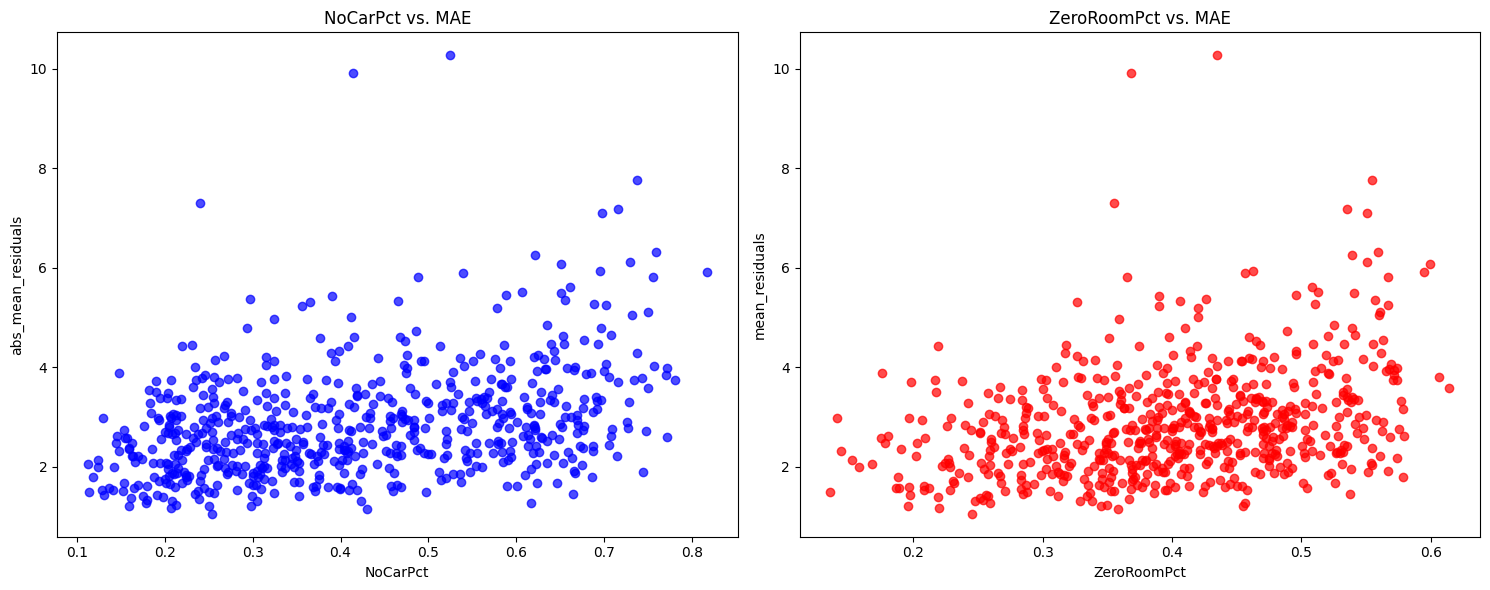

,ward_code,cluster,residuals,predicted,fitting_score_1,fitting_score_2,fitting_score_3,actual,orders_normal,orders_seasonal,NoCarPct,ZeroRoomPct,adj_pred,final_pred,final_mae,method_used,final_residual,final_fitting_score_1,final_fitting_score_2,final_fitting_score_3
0,E05009317,0,"[13.860902937191604, -0.2738253336081371, 13.9...","[12.139097062808396, 10.273825333608137, 8.093...",0.249539,0.156709,0.342368,"[26, 10, 22, 17, 21, 13, 11, 13, 13, 14, 17, 7...","(1, 1, 3)","(0, 1, 3, 12)",0.632145,0.484684,"[12.139097062808396, 10.273825333608137, 8.093...","[12.139097062808396, 10.273825333608137, 8.093...",3.968878,original,"[13.860902937191604, -0.2738253336081371, 13.9...",0.249539,0.156709,0.342368
1,E05009318,0,"[-7.701943933469407, -3.5133262448174696, -2.2...","[11.701943933469407, 7.51332624481747, 10.2818...",0.298018,0.232653,0.363384,"[4, 4, 8, 4, 13, 6, 9, 13, 5, 8, 6, 10, 9, 1, ...","(1, 1, 3)","(0, 1, 3, 12)",0.691681,0.577126,"[8.17434438750502, 3.9857266988530835, 6.75426...","[8.17434438750502, 3.9857266988530835, 6.75426...",2.163410,adjusted,"[-4.17434438750502, 0.014273301146916495, 1.24...",0.298018,0.232653,0.363384
2,E05009319,0,"[15.495348348638782, 5.210926762751942, 10.808...","[10.504651651361218, 6.789073237248058, 12.191...",0.212475,0.108991,0.315959,"[26, 12, 23, 13, 10, 12, 21, 19, 7, 16, 16, 17...","(1, 1, 3)","(0, 1, 3, 12)",0.650541,0.540274,"[13.93307082298461, 10.217492408871449, 15.620...","[13.93307082298461, 10.217492408871449, 15.620...",3.981776,adjusted,"[12.06692917701539, 1.7825075911285513, 7.3797...",0.212475,0.108991,0.315959
3,E05009320,0,"[7.110359520536017, 1.3426016600340827, 2.3994...","[5.889640479463983, 7.657398339965917, 8.60051...",0.167410,0.064108,0.270712,"[13, 9, 11, 15, 1, 2, 10, 3, 12, 12, 6, 7, 15,...","(1, 1, 3)","(0, 1, 3, 12)",0.577921,0.444402,"[5.889640479463983, 7.657398339965917, 8.60051...","[5.889640479463983, 7.657398339965917, 8.60051...",3.168275,original,"[7.110359520536017, 1.3426016600340827, 2.3994...",0.167410,0.064108,0.270712
4,E05009321,0,"[2.763178127599879, 11.245515142923665, 5.7280...","[5.236821872400121, 1.754484857076335, 3.27194...",0.436136,0.421234,0.451039,"[8.0, 13.0, 9.0, 3.0, 5.0, 9.0, 6.0, 6.0, 8.0,...","(1, 1, 3)","(0, 1, 3, 12)",0.640424,0.532069,"[5.236821872400121, 1.754484857076335, 3.27194...","[5.236821872400121, 1.754484857076335, 3.27194...",3.439892,original,"[2.763178127599879, 11.245515142923665, 5.7280...",0.436136,0.421234,0.451039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
626,E05014115,0,"[0.288228624536746, 4.119216414590856, 13.1050...","[7.711771375463254, 6.880783585409144, 6.89493...",0.325295,0.316742,0.333849,"[8, 11, 20, 9, 9, 8, 14, 10, 16, 7, 6, 7, 7, 9...","(1, 1, 3)","(0, 1, 3, 12)",0.525633,0.447277,"[7.711771375463254, 6.880783585409144, 6.89493...","[7.711771375463254, 6.880783585409144, 6.89493...",3.612649,original,"[0.288228624536746, 4.119216414590856, 13.1050...",0.325295,0.316742,0.333849
627,E05014116,1,"[-3.209290672354504, -0.9532296489944168, 1.57...","[4.209290672354504, 2.9532296489944168, 2.4242...",0.637712,0.694933,0.580490,"[1.0, 2.0, 4.0, 3.0, 3.0, 4.0, 5.0, 2.0, 2.0, ...","(2, 1, 2)","(0, 1, 2, 12)",0.497338,0.424015,"[4.209290672354504, 2.9532296489944168, 2.4242...","[4.209290672354504, 2.9532296489944168, 2.4242...",1.489059,original,"[-3.209290672354504, -0.9532296489944168, 1.57...",0.637712,0.694933,0.580490
628,E05014117,0,"[-3.3194329416203896, -0.7993714609064915, 1.1...","[6.31943294162039, 2.7993714609064915, 3.85214...",0.316359,0.217155,0.415563,"[3.0, 2.0, 5.0, 2.0, 3.0, 8.0, 6.0, 5.0, 12.0,...","(1, 1, 3)","(0, 1, 3, 12)",0.747097,0.562408,"[6.31943294162039, 2.7993714609064915, 3.85214...","[6.31943294162039, 2.7993714609064915, 3.85214...",2.721199,original,"[-3.3194329416203896, -0.7993714609064915, 1.1...",0.316359,0.217155,0.415563
629,E05014118,0,"[1.6126300258761042, 3.042951757535887, 6.0002...","[8.387369974123896, 6

In [46]:
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression

warnings.filterwarnings("ignore")

cluster_results = pd.merge(results_df, cluster_df, how="left", on="ward_code")
cluster_results.drop(columns=["cluster_y"], inplace=True)
cluster_results.rename(columns={"cluster_x": "cluster"}, inplace=True)

X = cluster_results[["NoCarPct", "ZeroRoomPct"]]
y = cluster_results["residuals"].apply(lambda x: np.mean(np.abs(x)))

p_cars = pearsonr(X["NoCarPct"], y)
s_cars = spearmanr(X["NoCarPct"], y)
p_rooms = pearsonr(X["ZeroRoomPct"], y)
s_rooms = spearmanr(X["ZeroRoomPct"], y)

# Print formatted correlations for NoCarPct relationships
print("Correlation between NoCarPct and MAE:")
print(f"  Pearson:  r = {p_cars[0]:.3f} (p-value = {p_cars[1]:.3f})")
print(f"  Spearman: r = {s_cars[0]:.3f} (p-value = {s_cars[1]:.3f})")

print("Correlation between NoCarPct and MAE:")
print(f"  Pearson:  r = {p_rooms[0]:.3f} (p-value = {p_rooms[1]:.3f})")
print(f"  Spearman: r = {s_rooms[0]:.3f} (p-value = {s_rooms[1]:.3f})")

# Plotting the scatter plots in a single figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Scatter plot for NoCarPct vs. abs_mean_residuals
ax[0].scatter(X["NoCarPct"], y, c="blue", alpha=0.7)
ax[0].set_xlabel("NoCarPct")
ax[0].set_ylabel("abs_mean_residuals")
ax[0].set_title("NoCarPct vs. MAE")

# Scatter plot for ZeroRoomPct vs. mean_residuals
ax[1].scatter(X["ZeroRoomPct"], y, c="red", alpha=0.7)
ax[1].set_xlabel("ZeroRoomPct")
ax[1].set_ylabel("mean_residuals")
ax[1].set_title("ZeroRoomPct vs. MAE")

plt.tight_layout()
plt.show()

model = LinearRegression()
model.fit(X, y)

# Apply cluster-specific adjustments and select best model
def apply_mae_adjustment_and_select(row):
    X_ward = [[row["NoCarPct"], row["ZeroRoomPct"]]]
    mae_adj = model.predict(X_ward)[0]

    # Determine direction based on mean residual
    mean_residual = np.mean(row["residuals"])
    sign = 1 if mean_residual >= 0 else -1

    # Create adjusted predictions
    adj_pred = row["predicted"] + sign * mae_adj

    # Calculate MAE for both models
    orig_mae = np.mean(np.abs(row["actual"] - row["predicted"]))
    adj_mae = np.mean(np.abs(row["actual"] - adj_pred))

    # Select the best model
    if adj_mae < orig_mae:
        return adj_pred, adj_mae, "adjusted"
    else:
        return row["predicted"], orig_mae, "original"

# Apply to all wards
new_results = []
for ward in cluster_results.to_dict("records"):
    adj_pred, final_mae, method = apply_mae_adjustment_and_select(ward)
    ward["adj_pred"] = adj_pred
    ward["final_pred"] = adj_pred if method == "adjusted" else ward["predicted"]
    ward["final_mae"] = final_mae
    ward["method_used"] = method
    ward["final_residual"] = ward["actual"] - ward["final_pred"]
    new_ocs, new_dvr, new_sp = oscillation_capture_score(ward["actual"], ward["final_pred"])
    ward["final_fitting_score_1"] = new_ocs
    ward["final_fitting_score_2"] = new_dvr
    ward["final_fitting_score_3"] = new_sp
    new_results.append(ward)

warnings.filterwarnings("default")

new_results_df = pd.DataFrame(new_results)

new_results_df


MAE Optimised Cluster Performance Metrics:
   cluster  n_wards   avg_mae  avg_rmse  fitting_score_1  fitting_score_2  \
0        0      225  3.022879  3.847922         0.301856         0.232271   
1        1      255  2.468015  3.144743         0.351381         0.310799   
2        2      151  2.183930  2.835165         0.426968         0.440678   

   fitting_score_3 normal_order seasonal_order  
0         0.371442    (1, 1, 3)  (0, 1, 3, 12)  
1         0.391962    (2, 1, 2)  (0, 1, 2, 12)  
2         0.413258    (3, 1, 1)  (0, 1, 1, 12)  


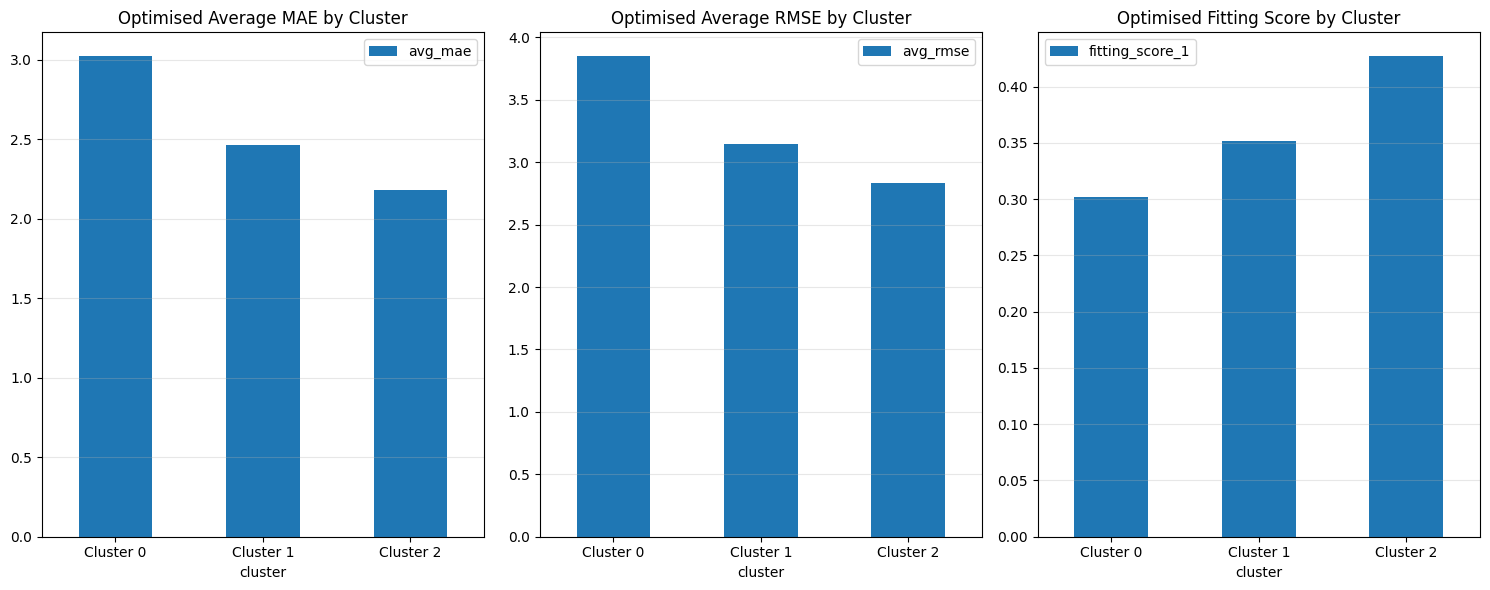

In [47]:
# Show the metrics after MAE optimsation

new_cluster_results = []
for cluster_id in range(3):
    new_cluster_data = new_results_df[new_results_df["cluster"] == cluster_id]
    new_cluster_mae = new_cluster_data["final_residual"].apply(lambda x: np.mean(np.abs(x))).mean()
    new_cluster_rmse = new_cluster_data["final_residual"].apply(lambda x: np.sqrt(np.mean(np.square(x)))).mean()

    new_cluster_results.append({
        "cluster": cluster_id,
        "n_wards": len(new_cluster_data),
        "avg_mae": new_cluster_mae,
        "avg_rmse": new_cluster_rmse,
        "fitting_score_1": new_cluster_data["final_fitting_score_1"].mean(),
        "fitting_score_2": new_cluster_data["final_fitting_score_2"].mean(),
        "fitting_score_3": new_cluster_data["final_fitting_score_3"].mean(),
        "normal_order": CLUSTER_ORDERS[cluster_id]["normal"],
        "seasonal_order": CLUSTER_ORDERS[cluster_id]["seasonal"]
    })

# Display results
new_cluster_metrics = pd.DataFrame(new_cluster_results)
print("\nMAE Optimised Cluster Performance Metrics:")
print(new_cluster_metrics[["cluster", "n_wards", "avg_mae", "avg_rmse", "fitting_score_1", "fitting_score_2", "fitting_score_3", "normal_order", "seasonal_order"]])

# Visualize comparison
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
new_cluster_metrics.plot(x="cluster", y="avg_mae", kind="bar", ax=ax[0], title="Optimised Average MAE by Cluster")
new_cluster_metrics.plot(x="cluster", y="avg_rmse", kind="bar", ax=ax[1], title="Optimised Average RMSE by Cluster")
new_cluster_metrics.plot(x="cluster", y="fitting_score_1", kind="bar", ax=ax[2], title="Optimised Fitting Score by Cluster")
for i in range(3):
    ax[i].set_xticklabels([f"Cluster {i}" for i in new_cluster_metrics["cluster"]], rotation=0)
    ax[i].grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

In [48]:
def plot_ward_predictions(row):
    # Create a new figure for each ward
    plt.figure(figsize=(10, 6))

    actual = row["actual"]
    predicted = row["predicted"]
    fitting_score = row["fitting_score"]

    # Generate a monthly date range starting at 2023-01-01 for TEST_MONTHS months.
    start_date = pd.to_datetime("2023-01-01")
    months = pd.date_range(start=start_date, periods=len(actual), freq="MS")

    # Calculate metrics
    orig_mae = mean_absolute_error(actual, predicted)
    orig_rmse = np.sqrt(mean_squared_error(actual, predicted))

    # Plot actual values
    plt.plot(months, actual, "o-", color="#2c3e50", linewidth=2, label="Actual")

    # Plot predictions based on method used
    if row["method_used"] == "original":
        plt.plot(months, row["predicted"], "s--", color="#e74c3c",
                linewidth=1.5, label="Original Prediction")
        final_mae = orig_mae
        final_rmse = orig_rmse
    else:
        plt.plot(months, row["predicted"], "s--", color="#95a5a6",
                alpha=0.7, linewidth=1, label="Original Prediction")
        plt.plot(months, row["adj_pred"], "s--", color="#27ae60",
                linewidth=1.5, label="Adjusted Prediction")
        final_mae = row["final_mae"]
        final_rmse = np.sqrt(mean_squared_error(actual, row["adj_pred"]))

    # Formatting
    plt.title(f"Ward: {row['ward_code']}\nMAE: {final_mae:.2f}, RMSE: {final_rmse:.2f}, Fitting Score: {fitting_score}", fontsize=12)
    plt.xlabel("Test Month Index", fontsize=10)
    plt.ylabel("Burglary Count", fontsize=10)
    plt.grid(alpha=0.3)
    plt.legend()

    # Add order info to plot
    order_text = (f"Order: {row['orders_normal']}\n"
                  f"Seasonal: {row['orders_seasonal']}\n"
                  f"Method: {row['method_used']}")
    plt.text(0.95, 0.05, order_text, transform=plt.gca().transAxes,
             ha="right", va="bottom", fontsize=9,
             bbox={"facecolor": "white", "alpha": 0.7})

    plt.tight_layout()
    plt.show()


# Plot all predictions of a cluster to quickly see the performance

cluster0_data = new_results_df[new_results_df["cluster"] == 0]
cluster1_data = new_results_df[new_results_df["cluster"] == 1]
cluster2_data = new_results_df[new_results_df["cluster"] == 2]


for _, (_, row) in enumerate(cluster0_data.iterrows()):
    plot_ward_predictions(row)